# Plot and Sort Backyard Brains Recordings

This notebook provides code to:

1. Import the wave file recorded with Spike Recorder
2. Plot the raw data
3. Determine a reasonable spike threshold
4. Detect spikes based on that threshold
5. Plot the raw waveforms & waveform features for detected spikes
6. Run a PCA on the extracted waveforms

*Note*: This code relies on several helper functions in `spikesorting_helperfunctions.py`. Please make sure this file is in the same folder as this notebook.

<hr>

## Setup

In [38]:
# Import packages we need 
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # configure high-resolution plotting
%run spikesorting_helperfunctions.py # import several helper functions for this analysis
print('Packages & Helper Functions Imported.')

Packages & Helper Functions Imported.


## Import wav file recorded with Spike Recorder
Below, we can import our recorded wav file and convert it to a numpy array.

You'll need to change the line marked below to import your file. Otherwise, you can try this with the sample recording (BYB_recording.wav) which contains about two minutes of recording from a cockroach leg.

In [39]:
from scipy.io.wavfile import read
byb_file = read('my_recording.wav')
entire_recording = np.array(byb_file[1],dtype=float)

# Get the time domain
sampling_freq = 10000 # SpikeRecorder acquires data at 10 kHz
timestamps = np.arange(len(entire_recording))/sampling_freq

# For signal values [-30K,30K], conversion is 1 unit = 6.7 nV
# This will therefore convert our signals to mV
conversion_factor = 6.7e-3
entire_recording *= conversion_factor

## Plot the raw data
Before doing any sorting, let's make sure our data looks okay by visualizing it below. If you want, you can change the `plt.xlim()` line to zoom in on the signal.

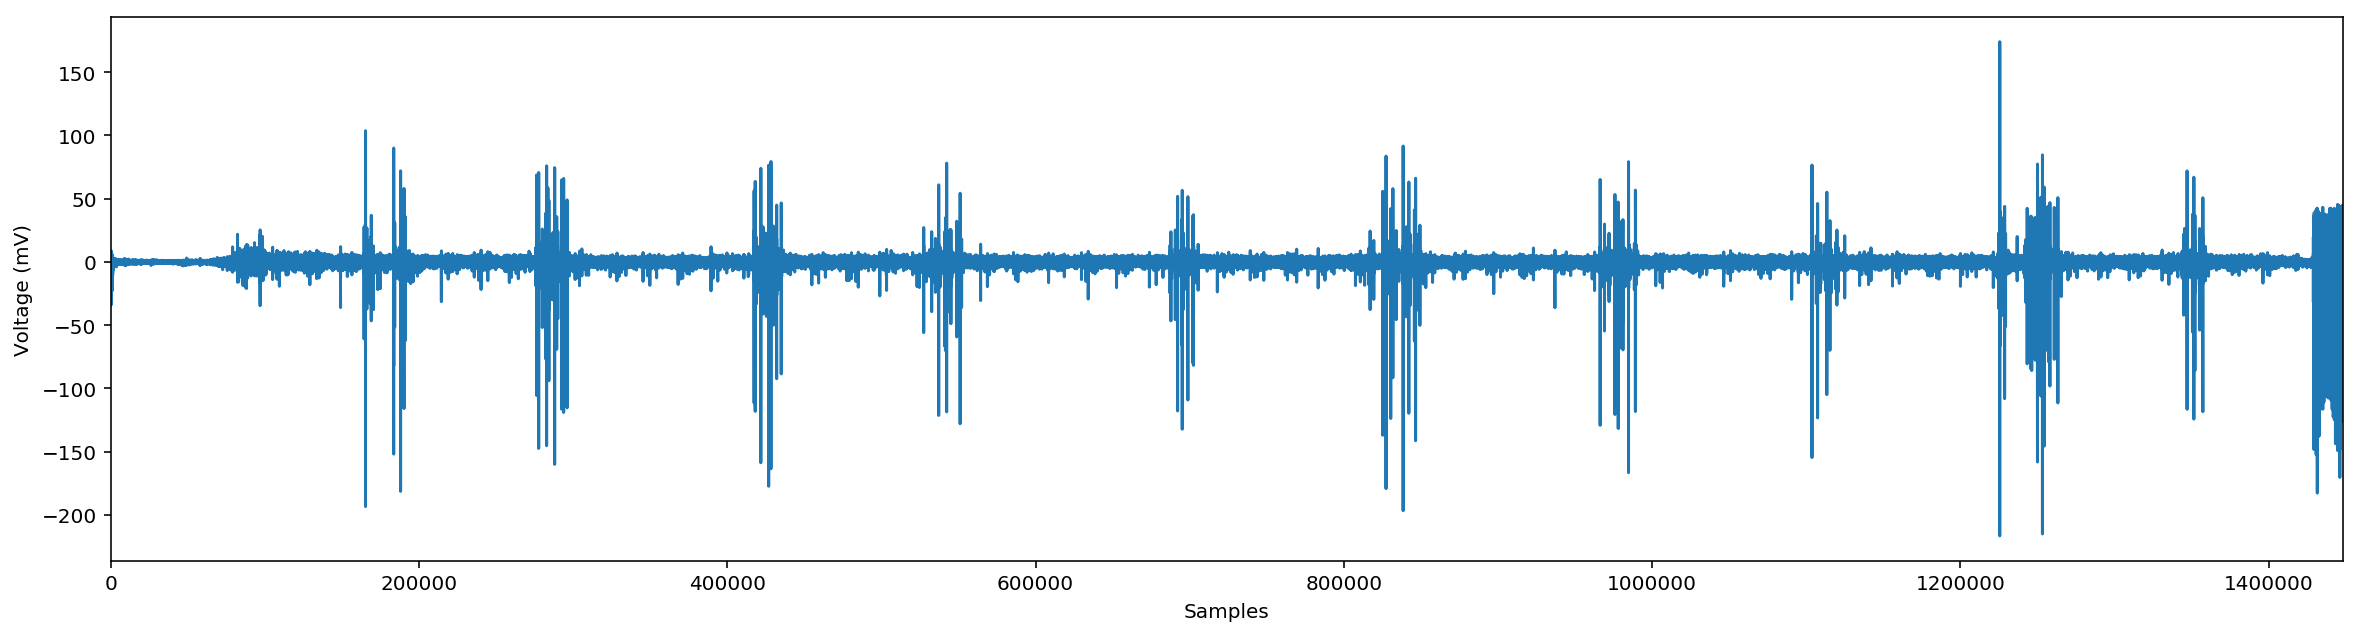

In [40]:
fig = plt.figure(figsize=(20,5))
plt.plot(entire_recording)
plt.xlabel('Samples')
plt.ylabel('Voltage (mV)')
plt.xlim([0,len(entire_recording)])
plt.show()

## Subselect a length of data to work with

Chances are, your recording includes turning the recording on in the beginning, and possibly some junk at the end too. Below, you can determine the `signal` we'll actually sort by changing the values in the brackets after `entire_recording`. These values should be in terms of samples (like the plot above), *not* time.

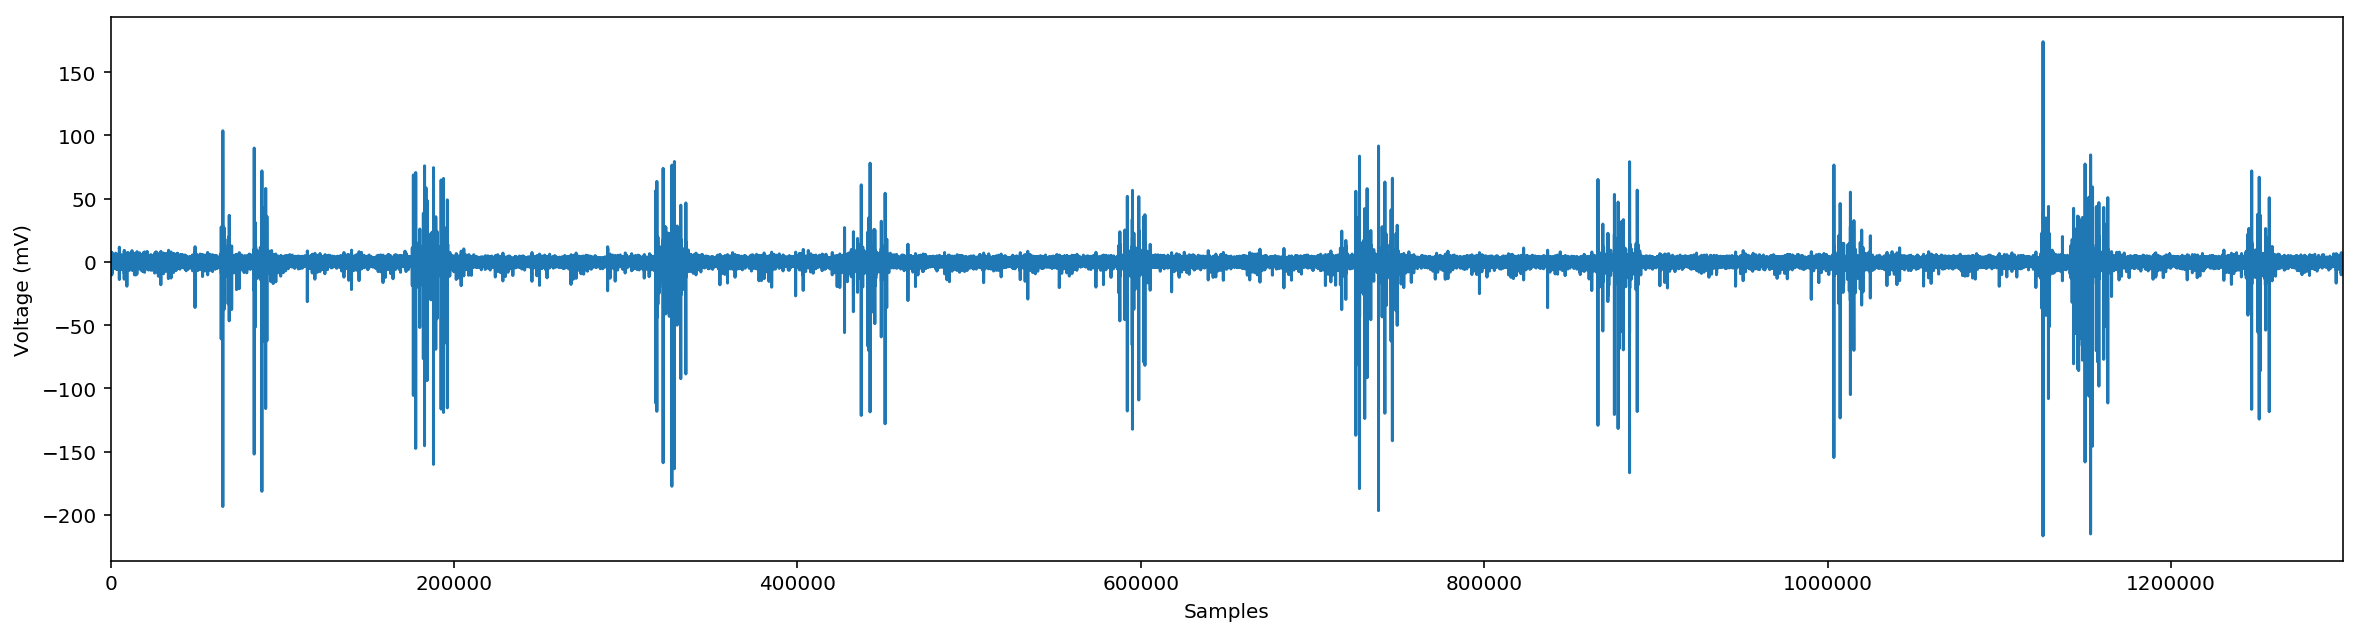

In [41]:
# Choose samples to work with (*not* timestamps)
signal_start = 100000
signal_end = 1400000
signal = entire_recording[signal_start:signal_end]
timestamps = timestamps[signal_start:signal_end]

# Plot the subselected data
fig = plt.figure(figsize=(20,5))
plt.plot(signal)
plt.xlabel('Samples')
plt.ylabel('Voltage (mV)')
plt.xlim([0,len(signal)])
plt.show()

# Spike sort!
## Determine a reasonable threshold & plot

We can empirically decide on a reasonable spike threshold by getting a sense of what the background noise in our recording looks like. To sort our spikes, we'll first determine the **standard deviation (std)** and **median absolute deviation** and use this to determine a recommended spike threshold.

In [42]:
noise_std = np.std(signal)
noise_mad = np.median(np.absolute(signal)) / 0.6745
recommended_threshold = -5 * noise_mad
print('Noise Estimate by Standard Deviation: {0:g} V'.format(noise_std))
print('Noise Estimate by MAD Estimator     : {0:g} V'.format(noise_mad))
print('Recommended Spike Threshold         : {0:g} V'.format(recommended_threshold))

Noise Estimate by Standard Deviation: 3.75948 V
Noise Estimate by MAD Estimator     : 1.41053 V
Recommended Spike Threshold         : -7.05263 V


## Determine a reasonable threshold & plot

You can choose to use the `recommended_threshold` saved above, or modify it to be your own, perhaps something more conservative. Either way, be sure to assign `spike_threshold` below. We'll then plot the data with this threshold, to make sure it looks reasonable.

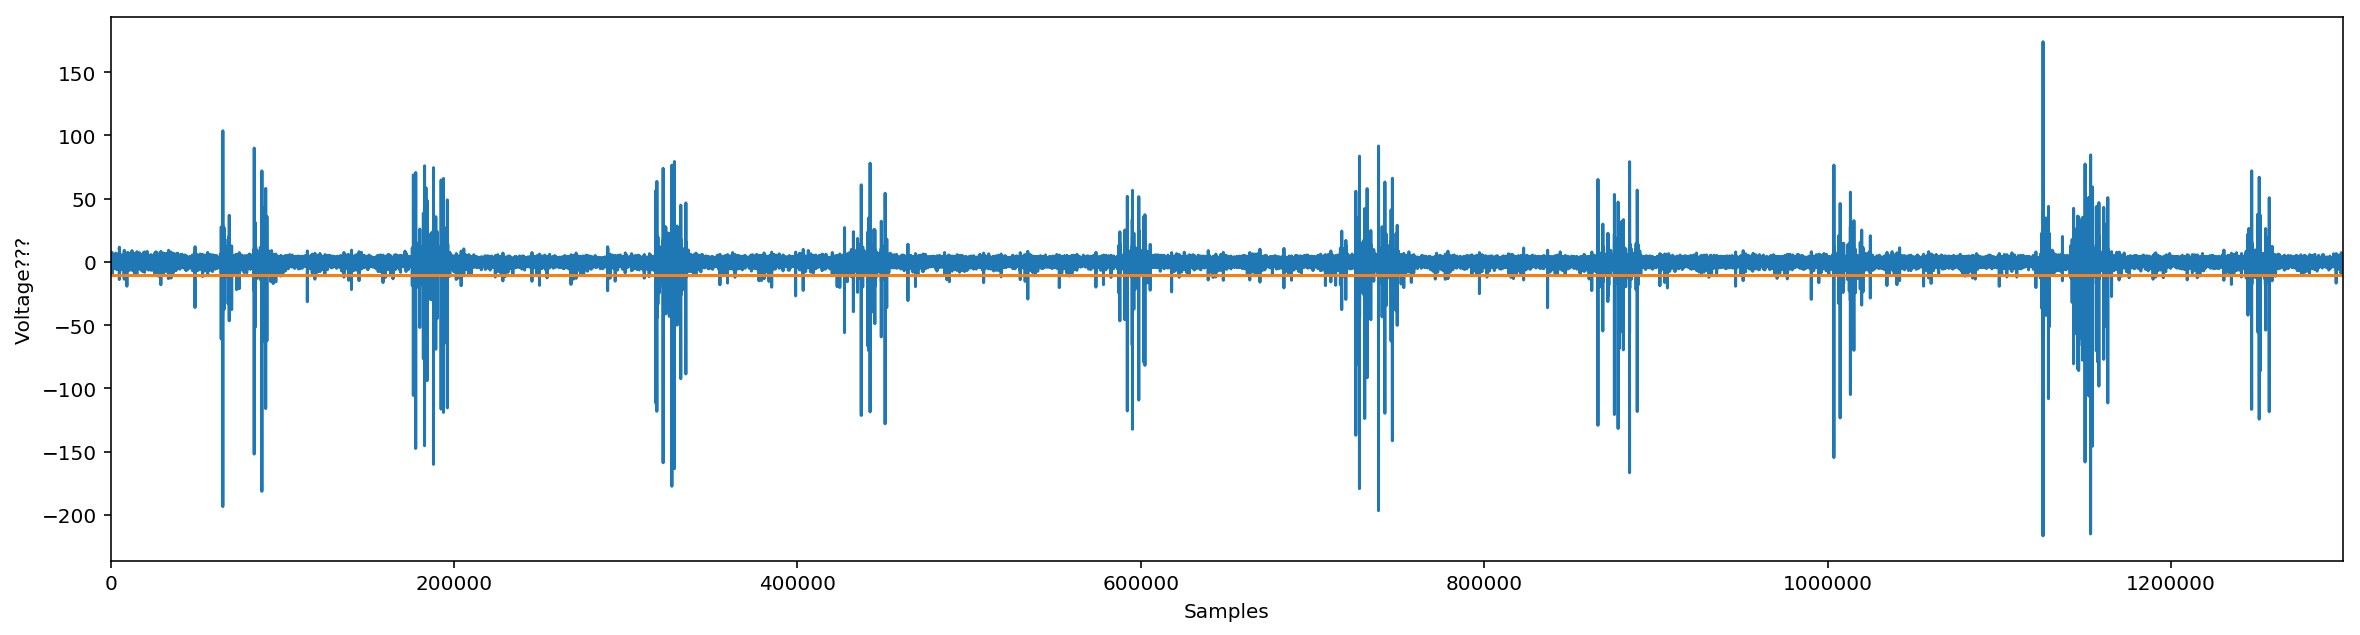

In [43]:
spike_threshold = -10 # Set your spike threshold here

fig = plt.figure(figsize=(20,5))
plt.plot(signal)
plt.xlabel('Samples')
plt.ylabel('Voltage???')
plt.plot([0, len(signal)], [spike_threshold, spike_threshold]) # add *1e6 to convert the threshold to µV for plotting
plt.xlim([0,len(signal)])
plt.show()

## Detect spikes and plot

Now, we'll detect spikes by looking for moments where the signal crosses our spike threshold. We'll define a 'dead time' in between our spikes, and a particular range to search within.

In [44]:
crossings = detect_threshold_crossings(signal, sampling_freq, spike_threshold, 0.003) # dead time of 3 ms?? -- fix
spks = align_to_minimum(signal, sampling_freq, crossings, 0.002) # search range 2 ms

Let's plot our data with the detected spikes. You might want to change `plt.xlim()` so that you can zoom in.

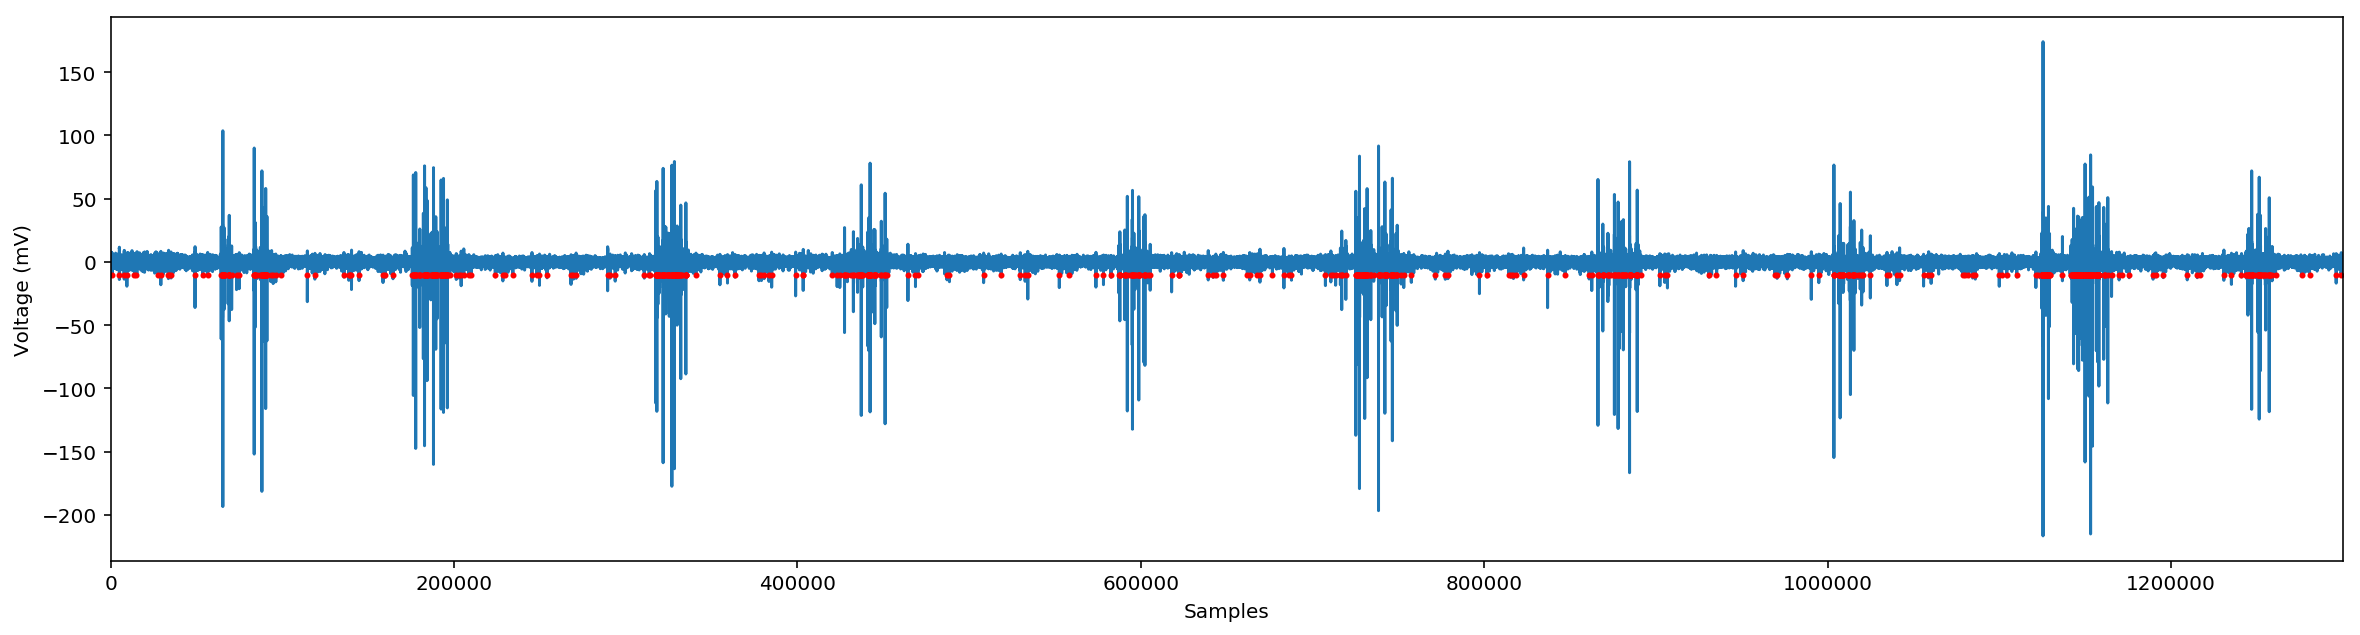

In [45]:
fig = plt.figure(figsize=(20,5))
plt.plot(signal)
plt.xlabel('Samples')
plt.ylabel('Voltage (mV)')
plt.plot(spks, [spike_threshold]*spks.shape[0], 'ro', ms=2)
plt.xlim([0,len(signal)])
plt.show()

### Zoom in on an action potential

To look at single action potentials, we'll plot our data in time, not samples. You can use the `plt.xlim` line to zoom in on a specific action potential.

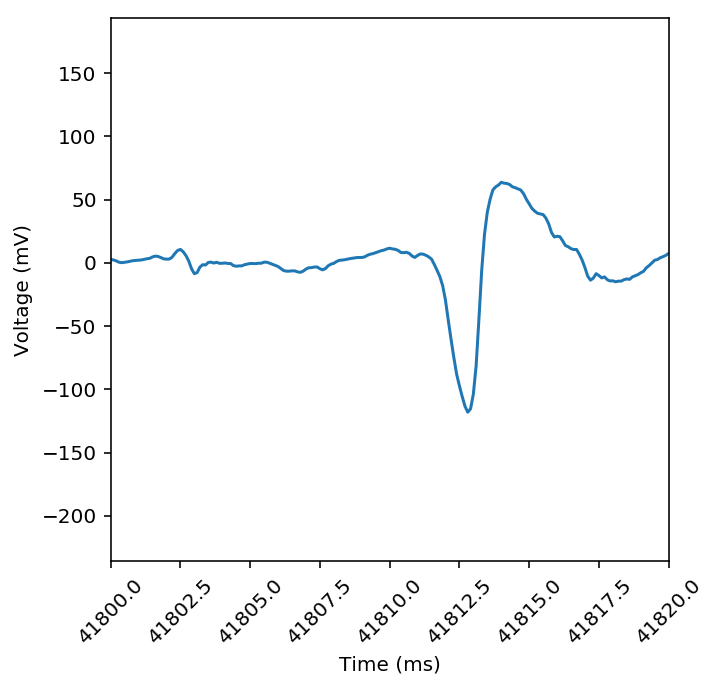

In [59]:
# put our timestamps in ms
timestamps_ms = timestamps*1000

fig = plt.figure(figsize=(5,5))
plt.plot(timestamps_ms,signal)
plt.xlabel('Time (ms)')
plt.ylabel('Voltage (mV)')
plt.xlim(41800,41820) # Change this for your data
plt.xticks(rotation = 45)
plt.show()

## Extract Waveforms
With our spikes detected, we can cut them out of the data and overlay them so that we can look at the waveform of our spike. We'll define a period before and after the spike to cut out.

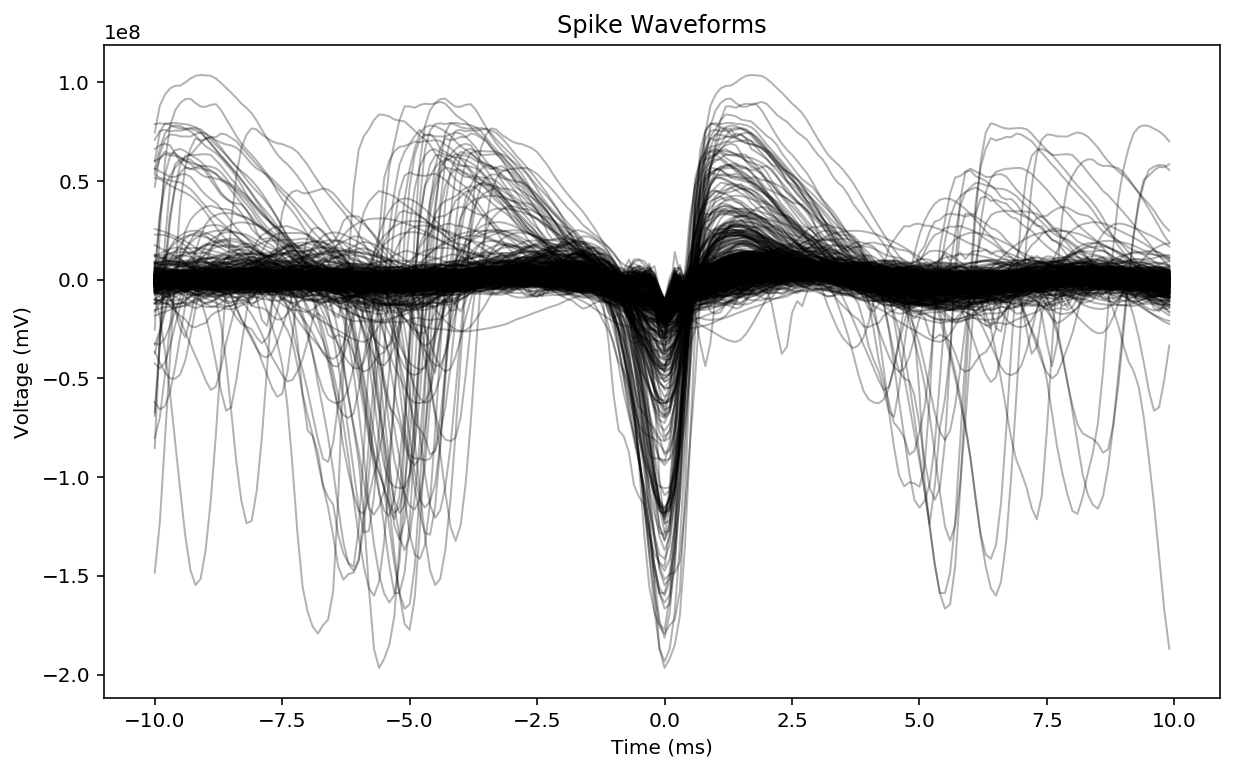

In [49]:
pre = 0.01 # 10 ms
post= 0.01 # 10 ms
waveforms = extract_waveforms(signal, sampling_freq, spks, pre, post)
plot_waveforms(waveforms, sampling_freq, pre, post, n=500)

## Run a PCA on extracted wavefroms

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_cutouts = scaler.fit_transform(waveforms)

pca = PCA()
pca.fit(scaled_cutouts)
#print(pca.explained_variance_ratio_)

pca.n_components = 3 # You could use 2 or 3, depending on the explained variance ratio...
transformed = pca.fit_transform(scaled_cutouts)

## Plot the results of our PCA

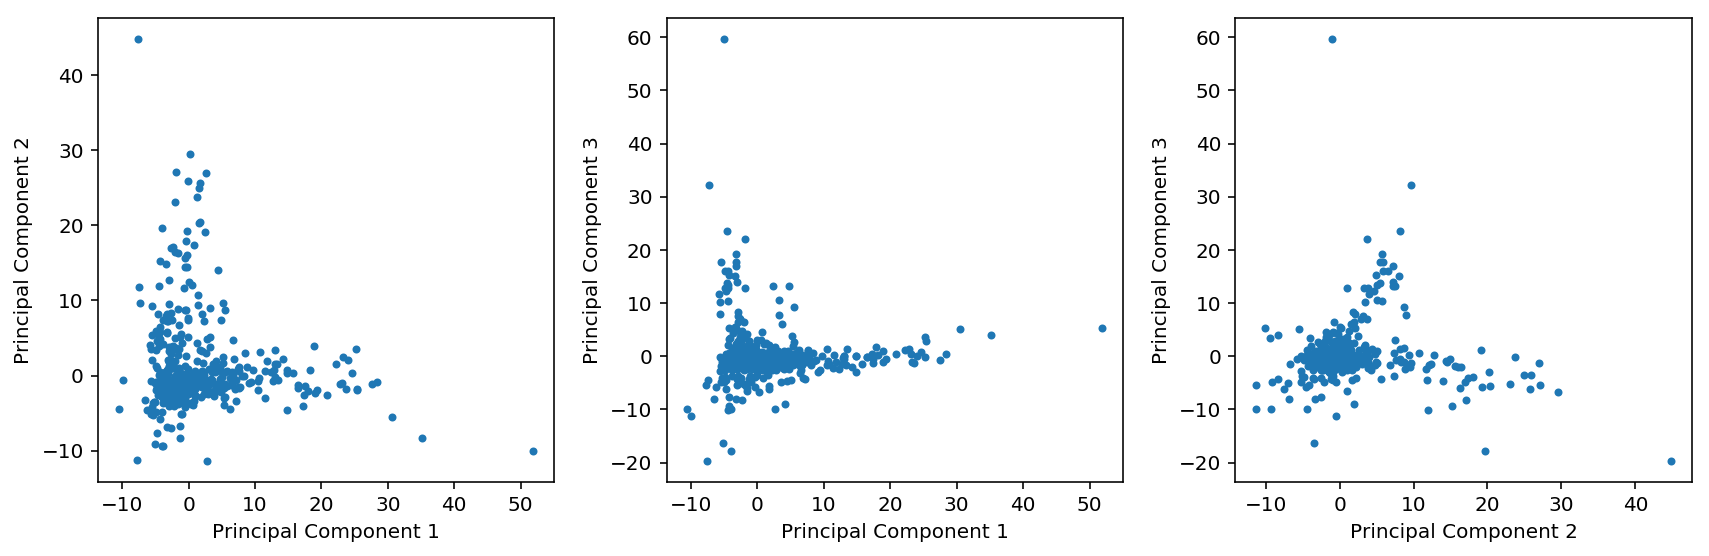

In [72]:
fig, ax = plt.subplots(1,3,figsize=(12,4))

ax[0].plot(transformed[:,0], transformed[:,1],'.')
ax[0].set_xlabel('Principal Component 1')
ax[0].set_ylabel('Principal Component 2')

if pca.n_components >=3:

    ax[1].plot(transformed[:,0], transformed[:,2],'.')
    ax[1].set_xlabel('Principal Component 1')
    ax[1].set_ylabel('Principal Component 3')

    ax[2].plot(transformed[:,1], transformed[:,2],'.')
    ax[2].set_xlabel('Principal Component 2')
    ax[2].set_ylabel('Principal Component 3')

plt.tight_layout()
plt.show()

## About this notebook
This notebook was largely inspired by [this tutorial](https://mcspydatatools.readthedocs.io/en/latest/McsPy-Tutorial_DataAnalysis.html).